# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import pandas as pd
import os
from os.path import isfile, join
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


#BASE = "./Dataset"
BASE = "gdrive/MyDrive/Final DatasetP"
cloth_folder = os.path.join(BASE, "Cloth Mask")
n95_folder = os.path.join(BASE, "N95")
n95valve_folder = os.path.join(BASE, "N95 mask with valve")
surgical_folder = os.path.join(BASE, "Surgical Mask")
without_mask_folder = os.path.join(BASE, "No Mask")
root_folder = ("./")



In [3]:
# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(root_folder, 'model/AI.pth')
make_dir(model_path)

# predefined classes
classes = {
    "cloth": 0,
    "n95": 1,
    "n95valve": 2,
    "surgical": 3,
    "without_mask": 4
}


In [4]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, images, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        self.dataset = images[int(indexes[0]):int(indexes[1])]
        
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        return image, self.dataset[index]['target']



In [5]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])

In [6]:

def load_images():
  dat = []
  cnt = 0   
  for filename in os.listdir(cloth_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(cloth_folder, filename)).convert('RGB')
        img = transform(img)
        sample['image'] = img
        sample['target'] = classes['cloth']
        dat.append(sample)
        cnt += 1
    except:
        continue
  print(cnt)

  for filename in os.listdir(n95_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95_folder, filename)).convert('RGB')
        img = transform(img)
        sample['image'] = img
        sample['target'] = classes['n95']
        dat.append(sample)
        cnt += 1
    except:
        continue
  print(cnt)

  for filename in os.listdir(n95valve_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95valve_folder, filename)).convert('RGB')
        img = transform(img)
        sample['image'] = img
        sample['target'] = classes['n95valve']
        dat.append(sample)
        cnt += 1
    except:
        continue
  print(cnt)

  for filename in os.listdir(surgical_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(surgical_folder, filename)).convert('RGB')
        img = transform(img)
        sample['image'] = img
        sample['target'] = classes['surgical']
        dat.append(sample)
        cnt += 1
    except:
        continue
  print(cnt)

  for filename in os.listdir(without_mask_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(without_mask_folder, filename)).convert('RGB')
        img = transform(img)
        sample['image'] = img
        sample['target'] = classes['without_mask']
        dat.append(sample)
        cnt += 1
    except:
        continue
  print(cnt)
  return dat



In [7]:

#load images into memory
images = load_images()
random.shuffle(images)
size_of_the_dataset = len(images)
print("size_of_the_dataset", size_of_the_dataset)



398
799
1200
1861
2379
size_of_the_dataset 2379


In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize((250, 250)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                        std=[0.229, 0.224, 0.225])])

In [ ]:

# print("Loading training set")
# train_dataset = FaceMaskDataset(images, train_indexes, conversion=transform)
# print("Train Dataset length ", len(train_dataset))

# print("Loading validation set")
# valid_dataset = FaceMaskDataset(images, test_indexes, conversion=transform)
# print("Validation Dataset length ", len(valid_dataset))

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [8]:


data = FaceMaskDataset(images,[0, size_of_the_dataset], conversion=transform)

print(len(data))
TEST_SIZE = 0.15

train_indices, test_indices= train_test_split(
    range(len(data)),
    test_size=TEST_SIZE,
    random_state = 42
)

train_indices = train_indices[ : int(0.834 * len(train_indices))]

print("Train split : {} test split : {} ".format( len(train_indices), len(test_indices)))

train_split = Subset(data, train_indices)
test_split = Subset(data, test_indices)

2379
Train split : 1686 test split : 357 


In [9]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        scores, predictions = torch.max(out.data, 1)
        train_correct = (predictions == labels).sum().item()
        return loss, train_correct

    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        scores, predictions = torch.max(out.data, 1)
        valid_correct = (predictions == labels).sum().item()
        return loss, valid_correct
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_accuracy: {:.4f}, valid_loss: {:.4f}, valid_accuracy: {:.4f}".format(epoch+1, result['train_loss'], result['train_accuracy']
                                                                                                                          , result['valid_loss'], result['valid_accuracy']))

In [12]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),     
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [13]:
@torch.no_grad()
def evaluate_model(model, val_loader):
    model.eval()
    valid_losses = []
    valid_correct = 0
   
    for batch in val_loader:
      loss, correct = model.validation_step(batch)
      valid_losses.append(loss)
      valid_correct += correct

    return valid_losses, valid_correct



def fit(epochs, lr, model, train_loader, valid_loader, opt_func = torch.optim.SGD):
    
    results = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_correct = 0
        for batch in train_loader:
            images, labels = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss, correct = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)
            train_correct += correct
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()

        valid_losses, valid_correct = evaluate_model(model, valid_loader)

        train_acc = (train_correct / (len(train_sampler))) * 100
        valid_acc = (valid_correct / (len(valid_sampler))) * 100
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = train_acc
        result['valid_loss'] = torch.stack(valid_losses).mean().item()
        result['valid_accuracy'] = valid_acc
        model.epoch_end(epoch, result)
        results.append(result)
    
    return results

In [14]:
model = CNN()
model = model.to(device)

In [15]:
from sklearn.model_selection import KFold
import numpy as np
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

num_epochs = 10
batch_size = 25
k = 10
splits = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf = {}
final_results = []

for fold, (train_idx,valid_idx) in enumerate(splits.split(np.arange(len(train_split)))):

    print('Fold {}'.format(fold + 1))
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = DataLoader(train_split, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_split, batch_size=batch_size, sampler=valid_sampler)

    results = fit(num_epochs, 0.0001, model, train_loader, valid_loader, torch.optim.ASGD)

    final_results.append(results)
    foldperf['fold{}'.format(fold+1)] = results  

Fold 1
Epoch [1], train_loss: 1.5531, train_accuracy: 37.1127, valid_loss: 1.4836, valid_accuracy: 52.0710
Epoch [2], train_loss: 1.4124, train_accuracy: 52.5379, valid_loss: 1.3325, valid_accuracy: 52.6627
Epoch [3], train_loss: 1.2678, train_accuracy: 58.6684, valid_loss: 1.1813, valid_accuracy: 59.7633
Epoch [4], train_loss: 1.1454, train_accuracy: 62.2281, valid_loss: 1.0741, valid_accuracy: 63.9053
Epoch [5], train_loss: 1.0443, train_accuracy: 65.5241, valid_loss: 1.0079, valid_accuracy: 65.0888
Epoch [6], train_loss: 0.9733, train_accuracy: 67.4357, valid_loss: 0.9372, valid_accuracy: 67.4556
Epoch [7], train_loss: 0.9119, train_accuracy: 70.7317, valid_loss: 0.8927, valid_accuracy: 66.2722
Epoch [8], train_loss: 0.8657, train_accuracy: 70.7317, valid_loss: 0.8467, valid_accuracy: 70.4142
Epoch [9], train_loss: 0.8287, train_accuracy: 72.8411, valid_loss: 0.8319, valid_accuracy: 69.2308
Epoch [10], train_loss: 0.7935, train_accuracy: 75.1483, valid_loss: 0.7967, valid_accuracy: 

In [16]:
torch.cuda.empty_cache()

In [ ]:
#torch.save(model.state_dict(), os.path.join(model_path,"model.pth"))

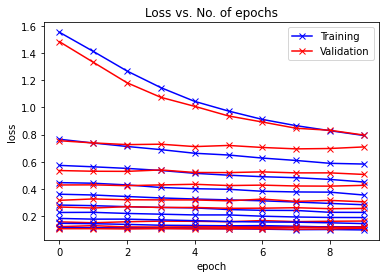

In [17]:
import matplotlib.pyplot as plt
def plot_losses(results):
    """ Plot the losses in each epoch"""

    for result in results:
      train_losses = [x.get('train_loss') for x in result]
      val_losses = [x['valid_loss'] for x in result]
      plt.plot(train_losses, '-bx')
      plt.plot(val_losses, '-rx')
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.legend(['Training', 'Validation'])
      plt.title('Loss vs. No. of epochs');

plot_losses(final_results)


In [18]:
test_loader = torch.utils.data.DataLoader(dataset=test_split, batch_size=batch_size, shuffle=True, num_workers=0)

In [19]:
y_true = torch.tensor([])
y_true = y_true.to(device)
y_preds = torch.tensor([])
y_preds = y_preds.to(device)


# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true = torch.cat((y_true, labels))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_preds = torch.cat((y_preds, predicted))
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

y_true = y_true.to('cpu')
y_preds = y_preds.to('cpu')


Test Accuracy of the model: 78.71148459383754 %


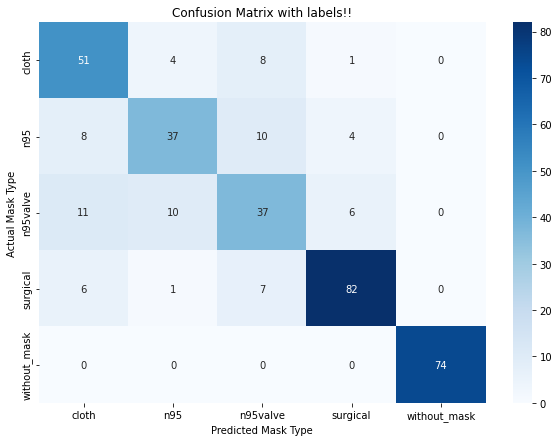

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# show confusion matrix
def show_confusion_matrix(y_true, y_preds):
    matrix = confusion_matrix(y_true, y_preds)
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels!!');
    ax.set_xlabel('Predicted Mask Type')
    ax.set_ylabel('Actual Mask Type')
    ax.xaxis.set_ticklabels([i for i in classes.keys()])
    ax.yaxis.set_ticklabels([i for i in classes.keys()])
    plt.show()

show_confusion_matrix(y_true, y_preds)


In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_true, y_preds)
print(classification_report(y_true,y_preds))

              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        64
         1.0       0.71      0.63      0.67        59
         2.0       0.60      0.58      0.59        64
         3.0       0.88      0.85      0.87        96
         4.0       1.00      1.00      1.00        74

    accuracy                           0.79       357
   macro avg       0.77      0.77      0.77       357
weighted avg       0.79      0.79      0.79       357

